In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns   

In [3]:
data = pd.read_csv("Company.csv")

Data Cleaning - Removal of NULL data values, checking for duplicating and refining the data

In [4]:
data.dtypes

Startup           object
Product           object
Funding           object
Event             object
Result            object
OperatingState    object
dtype: object

In [5]:
data.isnull().sum()

Startup             0
Product             6
Funding           214
Event               0
Result              0
OperatingState      0
dtype: int64

In [6]:
data['Funding'] = data['Funding'].fillna("$0M")

In [7]:
duplicates = data.duplicated()

print (duplicates.sum())

0


In [8]:
data['Funding'] = data['Funding'].str[1:]

In [9]:
#converting the funding to the integer values

def convert_if_ends_with_M(value):
    if value.endswith('M'):
        return int(float(value[:-1]) * 1000)
    else:
        return int(float(value[:-1]) * 1000)

# Apply the function to the column
data['Funding (in thousand dollars)'] = data['Funding'].apply(convert_if_ends_with_M)

new_data = data.drop(columns=['Funding'],axis=1)

In [10]:
new_data['Product']= new_data['Product'].fillna('None')

In [11]:
#storing none in events if participated in no events
new_data['Event'] = new_data['Event'].apply(lambda x:"None" if x=="-" else x)

In [12]:
# Function to extract event year
def extract_last_four_as_integer(value):
    if value!='None' and len(value) >= 4:
        return int(float(value[-4:]))
    else:
        return None

new_data['EventYear'] = new_data['Event'].apply(extract_last_four_as_integer)

#funtion to find the event name and how old is the event
new_data['EventName'] = new_data['Event'].str[:-4]
new_data['EventAge'] = 2024 - new_data['EventYear']
new_data['EventAge'] = new_data['EventAge'].fillna(0)

clean_data = new_data.drop(columns=['Event', 'EventYear'],axis=1)

In [13]:
clean_data

,Startup,Product,Result,OperatingState,Funding (in thousand dollars),EventName,EventAge
0,2600Hz,2600hz.com,Contestant,Operating,0,Disrupt SF,11.0
1,3DLT,3dlt.com,Contestant,Closed,630000,Disrupt NYC,11.0
2,3DPrinterOS,3dprinteros.com,Contestant,Operating,0,Disrupt SF,8.0
3,3Dprintler,3dprintler.com,Audience choice,Operating,1000,Disrupt NY,8.0
4,42 Technologies,42technologies.com,Contestant,Operating,0,Disrupt NYC,11.0
...,...,...,...,...,...,...,...
657,Zivity,zivity.com,Contestant,Operating,8000,TC40,17.0
658,Zmorph,zmorph3d.com,Audience choice,Operating,1000,,0.0
659,Zocdoc,zocdoc.com,Contestant,Operating,223000,TC40,17.0
660,Zula,zulaapp.com,Audience choice,Operating,3400,Disrupt SF,11.0


Q1 - IS THERE ANY SIGNIFICANT DIFFERENCE BETWEEN FUNDS RAISED BY COMPANIES THAT ARE STILL OPERATING VS COMPANIES THAT CLOSED DOWN?

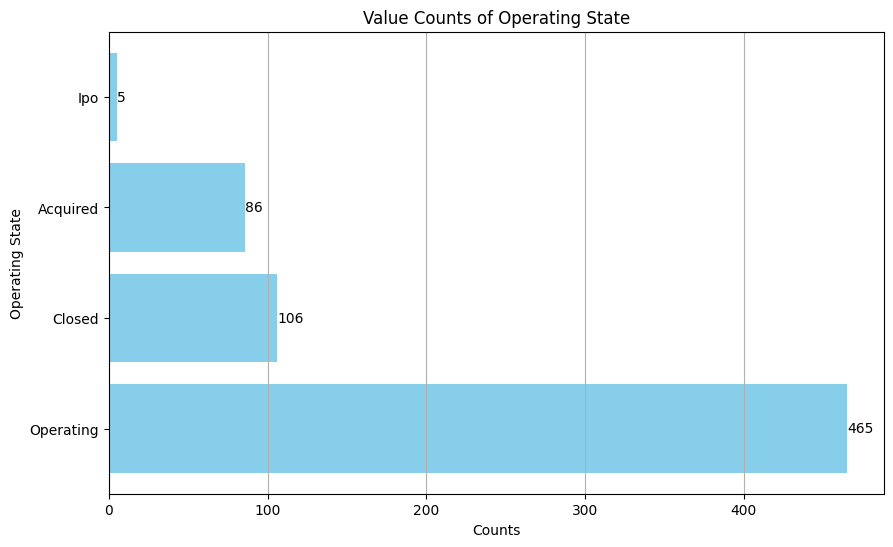

In [14]:
value_counts = clean_data['OperatingState'].value_counts()

#plotting of the counts
plt.figure(figsize=(10, 6))
bars = plt.barh(value_counts.index, value_counts.values, color='skyblue')
plt.title('Value Counts of Operating State')
plt.xlabel('Counts')
plt.ylabel('Operating State')
plt.grid(axis='x')

# Adding text labels on each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{int(bar.get_width())}', va='center', ha='left')

plt.show()

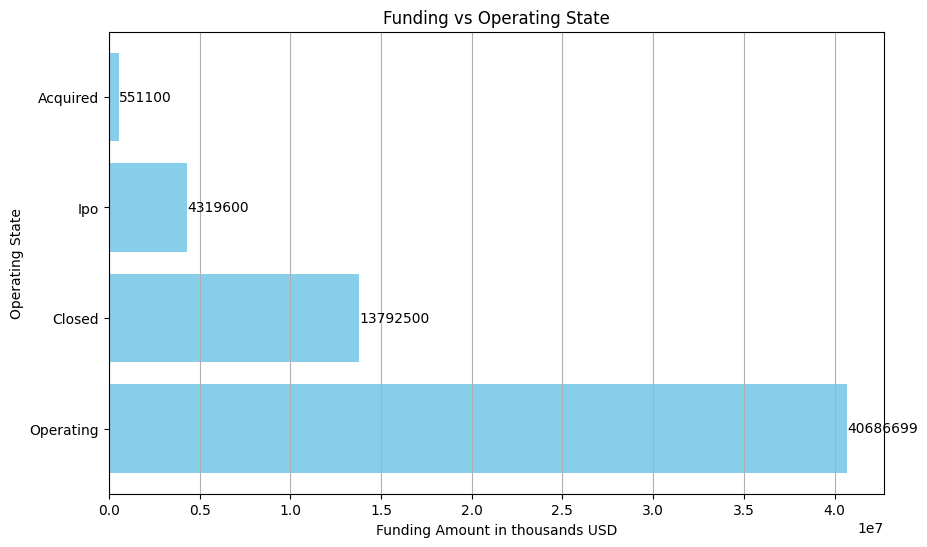

In [15]:
#finding the difference in funding amounts of various companies

sum1 = clean_data.loc[clean_data['OperatingState'] == 'Operating','Funding (in thousand dollars)'].sum()
sum2 = clean_data.loc[clean_data['OperatingState'] == 'Closed','Funding (in thousand dollars)'].sum()
sum3 = clean_data.loc[clean_data['OperatingState'] == 'Ipo','Funding (in thousand dollars)'].sum()
sum4 = clean_data.loc[clean_data['OperatingState'] == 'Acquired','Funding (in thousand dollars)'].sum()

# Extracting keys and values
operating_state = ['Operating','Closed','Ipo','Acquired']
funding_amount = [sum1,sum2,sum4,sum3]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(operating_state, funding_amount, color='skyblue')
plt.title('Funding vs Operating State')
plt.xlabel('Funding Amount in thousands USD')
plt.ylabel('Operating State')
plt.grid(axis='x')

# Adding text labels on each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width()}', va='center', ha='left')

plt.show()


As we can see that the funding has a significant difference between the companies that are in 'Closed' state vs the one that are in 'Operating' State. Before sending this data for training, it is advised to upsample the data related to 'Closed' state so that the training of the model is not biased while learning from the training data.





Q2 - WRITE THE NULL HYPOTHESIS AND ALTERNATIVE HYPOTHESIS

In [16]:
#checking the dependency between Funding and Operating State columns using Chi-test analysis
from scipy import stats

df = clean_data[['Funding (in thousand dollars)','OperatingState']]
# Binning the numeric feature into categories
df['NumericFeatureBinned'] = pd.cut(df['Funding (in thousand dollars)'], bins=[0, 330000,660000 ,990000 ], labels=['Low', 'Medium', 'High'])
print("\nDataFrame with Binned Numeric Feature:")

# Creating a contingency table
contingency_table = pd.crosstab(df['NumericFeatureBinned'], df['OperatingState'])
print("\nContingency Table:")
print(contingency_table)

# Performing Chi-Square Test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
critical_value = stats.chi2.ppf(1 - 0.05, dof)
print("\nChi-Square Test Results:")
print (f"Critical Value: {critical_value}")
print(f"Chi2 Statistic: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies Table:")
print(expected)


DataFrame with Binned Numeric Feature:

Contingency Table:
OperatingState        Acquired  Closed  Ipo  Operating
NumericFeatureBinned                                  
Low                         62      42    3        270
Medium                       2       8    1         29
High                         2       8    0         21

Chi-Square Test Results:
Critical Value: 12.591587243743977
Chi2 Statistic: 12.753667036107872
P-Value: 0.047118849657972264
Degrees of Freedom: 6
Expected Frequencies Table:
[[ 55.54017857  48.80803571   3.36607143 269.28571429]
 [  5.89285714   5.17857143   0.35714286  28.57142857]
 [  4.56696429   4.01339286   0.27678571  22.14285714]]


/var/folders/qd/0lrktpjd7vx07f15zzz6l5vw0000gn/T/ipykernel_42744/1658262450.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NumericFeatureBinned'] = pd.cut(df['Funding (in thousand dollars)'], bins=[0, 330000,660000 ,990000 ], labels=['Low', 'Medium', 'High'])


Q3- TEST FOR SIGNIFICANCE AND CONCLUSION - 
since the chi2-statistic is larger than the critical value & p-value is less than 0.05(5% of false positives is considered), null hypothesis can be rejected and there is association between the two

Q4 - MAKE A COPY OF THE DATAFRAME

In [17]:
#deep copy of the dataframe
deep_copy_clean_data = clean_data.copy(deep=True)

#shallow copy of the dataframe
shallow_copy_clean_data = clean_data.copy()

Q5 CHECK FREQUENCY DISTRIBUTION OF RESULT VARIABLES

In [18]:
result_counts = clean_data['Result'].value_counts()
print (result_counts)

Result
Contestant         488
Finalist            84
Audience choice     41
Winner              26
Runner up           23
Name: count, dtype: int64


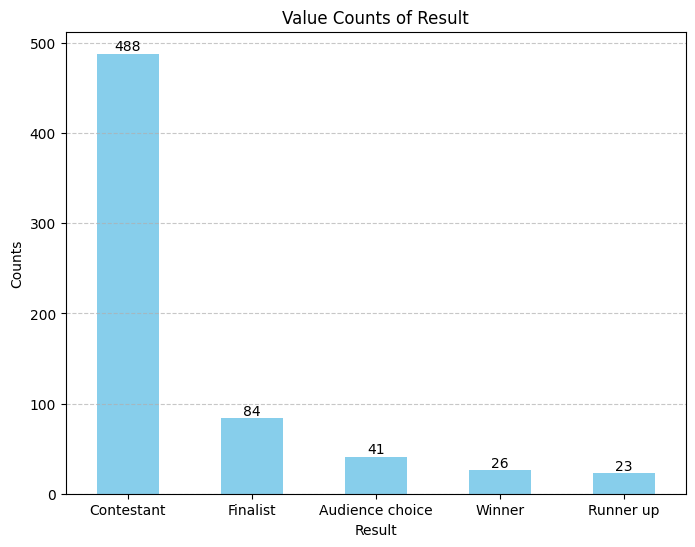

In [19]:
# Plotting
plt.figure(figsize=(8, 6))
bars = result_counts.plot(kind='bar', color='skyblue')

# Annotate each bar with its count
for bar in bars.patches:
    plt.annotate(format(bar.get_height(), '.0f'),
                 (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 ha='center', va='bottom', fontsize=10, color='black')

plt.title('Value Counts of Result')
plt.xlabel('Result')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Q6 - CALCULATE PERCENTAGE OF WINNERS THAT ARE STILL OPERATING AND PERCENTAGE OF CONTESTANTS THAT ARE STILL OPERATING 

In [20]:
#percentage of winners in operating state - (winners in operating state / all startups in operating state) *100
operating_winners_count = clean_data[(clean_data['Result']=='Winner') & (clean_data['OperatingState'] == 'Operating')].shape[0]
operating_total_count = clean_data[clean_data['OperatingState'] == 'Operating'].shape[0]
percentage_winners_operating_state = ((operating_winners_count)/(operating_total_count)) * 100
print (f"The percentage of winners in operating state : {percentage_winners_operating_state}")

#percentage of contestants in operating state - (contestants in operating state / all startups in operating state) *100
operating_contestants_count = clean_data[(clean_data['Result']=='Contestant') & (clean_data['OperatingState'] == 'Operating')].shape[0]
percentage_contestants_operating_state = ((operating_contestants_count)/(operating_total_count)) * 100
print (f"The percentage of contestants in operating state:{percentage_contestants_operating_state}")

The percentage of winners in operating state : 4.086021505376344
The percentage of contestants in operating state:71.3978494623656


Q7 - WRITE YOUR HYPOTHESIS COMPARING THE PROPORTION OF COMPANIES THAT ARE OPERATING BETWEEN WINNERS AND CONTESTANTS

In [27]:
company_winner = clean_data[clean_data['Result'] == 'Winner']
company_winner_operating = clean_data[(clean_data['OperatingState'] == 'Operating') & (clean_data['Result'] == 'Winner')]

company_contestant = clean_data[clean_data['Result'] == 'Contestant']
company_contestant_operating = clean_data[(clean_data['OperatingState'] == 'Operating') & (clean_data['Result'] == 'Contestant')]

In [29]:
print (f"Company in operating state with winners : {company_winner_operating.shape[0]/ company_winner.shape[0]}")

print (f"Company in operating state with contestants : {company_contestant_operating.shape[0]/company_contestant.shape[0]}")

Company in operating state with winners : 0.7307692307692307
Company in operating state with contestants : 0.680327868852459


Q8 - TEST FOR SIGNIFICANCE AND CONCLUSION

There is not a lot of difference in the proportion of company in operating with winners and company in operating state with contestants. Therefore null hypothesis is applicable and alternate hypothesis can be rejected  

Q9 - SELECT ONLY THE EVENT THAT HAS ‘DISRUPT’ KEYWORD FROM 2013 ONWARDS

In [30]:
clean_data

,Startup,Product,Result,OperatingState,Funding (in thousand dollars),EventName,EventAge
0,2600Hz,2600hz.com,Contestant,Operating,0,Disrupt SF,11.0
1,3DLT,3dlt.com,Contestant,Closed,630000,Disrupt NYC,11.0
2,3DPrinterOS,3dprinteros.com,Contestant,Operating,0,Disrupt SF,8.0
3,3Dprintler,3dprintler.com,Audience choice,Operating,1000,Disrupt NY,8.0
4,42 Technologies,42technologies.com,Contestant,Operating,0,Disrupt NYC,11.0
...,...,...,...,...,...,...,...
657,Zivity,zivity.com,Contestant,Operating,8000,TC40,17.0
658,Zmorph,zmorph3d.com,Audience choice,Operating,1000,,0.0
659,Zocdoc,zocdoc.com,Contestant,Operating,223000,TC40,17.0
660,Zula,zulaapp.com,Audience choice,Operating,3400,Disrupt SF,11.0


In [32]:
event_company_2013_disrupt = clean_data[(clean_data['EventName'].str.contains('Disrupt')) & (clean_data['EventAge'] >= 2024-2013)]

print (event_company_2013_disrupt)

              Startup             Product           Result OperatingState  \
0              2600Hz          2600hz.com       Contestant      Operating   
1                3DLT            3dlt.com       Contestant         Closed   
4     42 Technologies  42technologies.com       Contestant      Operating   
6        8 Securities     8securities.com         Finalist      Operating   
8    About Last Night  aboutlastnight.net       Contestant      Operating   
..                ...                 ...              ...            ...   
652             Yuwan           iyuwan.cn       Contestant         Closed   
654              ZEFR            zefr.com       Contestant      Operating   
656          Zenefits        zenefits.com         Finalist      Operating   
660              Zula         zulaapp.com  Audience choice      Operating   
661            Zumper          zumper.com         Finalist      Operating   

     Funding (in thousand dollars)         EventName  EventAge  
0         